<a href="https://colab.research.google.com/github/Ash100/DiSHaN/blob/main/DiSHaN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DiSHaN:** (**Di**versity, **S**egregation, **Ha**plotypes, and **N**etworks)

DiSHaN pipeline is generated by **Dr. Ashfaq Ahmad** and you are allowed to use them for accademic teachings and research purposes. Publication is under review and will be updated here - once published.


#Contents
1. Nucleotide Diversity
2. Segregating Sites (Gene Segregation)
3. Haplotypes Distribution
4. Haplotypes Networking

**Nucleotide Diversity (Pi)**
Nucleotide diversity is a molecular genetics concept that measures the amount of genetic variation in a population (sequence alignment you input). Nucleotide diversity can be measured in terms of allele or haplotype frequencies.

**Segregation**
The process by which individual genes are separated and passed down from parents to offspring.

**Segregating Sites**
Segregating sites are positions in a sequence alignment that show differences between related genes.

**Haplotypes / Haplotypes Distribution or Frequeny** A haplotype is a group of genes or DNA variants that are inherited together from a single parent.

**Haplotypes Networking** A haplotype network is a visual representation of the relationships different haplotypes in a population (sequences used). It is useful in infering evolutionary relationships.

In [ ]:
#@title Step 1: Install and Import Necessary Libraries
!pip install biopython

# Step 2: Import Libraries
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

**Instructions for step 2:**

Once you run the code below, a pop-up window will appears, asking you to insert **Accession Number** of your sequence. Just provide and hit enter.

Another window will appear, asking for **Gene Name**. Provide and hit enter

Finally, a similar window will appear, asking you to provide **Nucleotide Sequence**.

In [4]:
#@title Step 2: Provide Sequence Information in Stages

# Step 3.1: Get Accession Number
accession_number = input("Enter the accession number for the sequence (e.g., NM_001200):\n").strip()

# Step 3.2: Get Gene Name
gene_name = input("Enter the gene name (e.g., rbcL):\n").strip()

# Step 3.3: Get Sequence
raw_sequence = input("Paste your sequence (no header required; only the sequence):\n").strip()

# Sanitize the sequence: remove spaces, newlines, and convert to uppercase
sequence = "".join(raw_sequence.split()).upper()

# Validate the sequence
if not sequence or any(char not in "ATCGN" for char in sequence):
    raise ValueError("Invalid sequence. Ensure it contains only nucleotide characters (A, T, C, G, N).")
if len(sequence) < 15:
    raise ValueError("Sequence is too short for a BLAST search. Provide a longer sequence.")

# Step 3.4: Create FASTA Format
header = f">{accession_number} | {gene_name}"
fasta_content = f"{header}\n{sequence}"

# Save to a FASTA file
with open("input_sequence.fasta", "w") as file:
    file.write(fasta_content)

print("FASTA file created successfully as 'input_sequence.fasta'.")


KeyboardInterrupt: Interrupted by user

In [65]:
#@title Save the sequence to a FASTA file
with open("input_sequence.fasta", "w") as file:
    file.write(sequence)

Performing BLAST Search on the provided sequence

In [67]:
#@title Step 3: Perform BLAST
# Submit the sequence to NCBI BLAST
with open("input_sequence.fasta") as fasta_file:
    result_handle = NCBIWWW.qblast("blastn", "nt", fasta_file.read())

# Save the BLAST result to a file
with open("blast_result.xml", "w") as result_file:
    result_file.write(result_handle.read())

In [68]:
#@title Step 4: Parse BLAST Results and Save Alignments in `.fas`

from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Parse the BLAST XML result
blast_records = NCBIXML.parse(open("blast_result.xml"))

# Extract and save alignments in FASTA format
records = []
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            record = SeqRecord(Seq(hsp.sbjct), id=alignment.hit_id, description=alignment.hit_def)
            records.append(record)

# Save the alignments to a FASTA file
SeqIO.write(records, "alignments.fas", "fasta")

50

The above step actually ran the BLAST on the provided sequence. The resultant sequences are downloaded in XML format which was further converted into FASTA file.

In Step 4 below, we are going to install **Muscle** and will be used for aligning the retrieved sequences.

In [ ]:
#@title Install Muscle Alignment Package
!apt-get install muscle

In [73]:
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline

# Read the sequences from the FASTA file
sequences = list(SeqIO.parse("alignments.fas", "fasta"))

# Create a Muscle command
muscle_cline = MuscleCommandline(input="alignments.fas", out="aligned_sequences.fas")

# Run the Muscle command
muscle_cline()

print("Alignment complete. Aligned sequences saved to aligned_sequences.fas")

Alignment complete. Aligned sequences saved to aligned_sequences.fas


In [ ]:
#Step 6: Allow Exclusion of Sequences
# Load the alignment file
alignment_records = list(SeqIO.parse("aligned_sequences.fas", "fasta"))

# Display sequence IDs for exclusion
print("Sequence IDs in the alignment:")
for i, record in enumerate(alignment_records):
    print(f"{i + 1}: {record.id}")

# User input to exclude sequences
exclude_indices = input("Enter the indices of sequences to exclude (comma-separated): ")
exclude_indices = list(map(int, exclude_indices.split(",")))

# Filter the sequences
filtered_records = [record for i, record in enumerate(alignment_records) if (i + 1) not in exclude_indices]

# Step 7: Save the Filtered Alignments
# Save the filtered sequences to a new FASTA file
SeqIO.write(filtered_records, "filtered_alignments.fas", "fasta")

print("Filtered alignments saved to 'filtered_alignments.fas'.")

In [70]:
#@title Import of necessary libraries
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
import numpy as np

In [74]:
#@title Calculate Nucleotide Diversity (Pi)
alignment = MultipleSeqAlignment(SeqIO.parse("aligned_sequences.fas", "fasta"))

# Function to calculate nucleotide diversity (Pi)
def calculate_nucleotide_diversity(alignment):
    num_sequences = len(alignment)
    num_sites = alignment.get_alignment_length()
    pairwise_differences = 0
    for i in range(num_sequences):
        for j in range(i + 1, num_sequences):
            pairwise_differences += sum(base1 != base2 for base1, base2 in zip(alignment[i].seq, alignment[j].seq))
    total_comparisons = num_sequences * (num_sequences - 1) / 2
    nucleotide_diversity = pairwise_differences / (total_comparisons * num_sites)
    return nucleotide_diversity

# Calculate nucleotide diversity
nucleotide_diversity = calculate_nucleotide_diversity(alignment)
print("Nucleotide diversity (Pi):", nucleotide_diversity)

Nucleotide diversity (Pi): 0.005055297366471341


In [75]:
#@title Calculate segregating sites

from Bio import AlignIO

def calculate_segregating_sites(alignment):
    """
    Calculate the number of segregating sites in a multiple sequence alignment.

    Parameters:
    - alignment: A MultipleSeqAlignment object from Biopython.

    Returns:
    - segregating_sites: Number of segregating sites in the alignment.
    """
    num_sites = alignment.get_alignment_length()
    segregating_sites = 0

    for i in range(num_sites):
        column = alignment[:, i]
        unique_bases = set(column)
        if len(unique_bases) > 1:
            segregating_sites += 1

    return segregating_sites

# Load your alignment file (adjust the file path and format as needed)
alignment = AlignIO.read("/content/aligned_sequences.fas", "fasta")  # Change to your file and format

# Calculate segregating sites
segregating_sites = calculate_segregating_sites(alignment)
print(f"Segregating Sites: {segregating_sites}")

Segregating Sites: 33


In [76]:
#@title Calculate segregating sites

from Bio import AlignIO

def calculate_segregating_sites(alignment):
    """ Calculate the number of segregating sites in a multiple sequence alignment.

    Parameters:
    - alignment: A MultipleSeqAlignment object from Biopython.

    Returns:
    - segregating_sites: Number of segregating sites in the alignment.
    """
    num_sites = alignment.get_alignment_length()
    segregating_sites = 0
    for i in range(num_sites):
        column = alignment[:, i]
        unique_bases = set(column)
        if len(unique_bases) > 1:
            segregating_sites += 1
    return segregating_sites

# Ask the user for the file name
file_name = input("Please enter the name of your alignment file (e.g., aligned_sequences.fas): ")

# Load the alignment file
try:
    alignment = AlignIO.read(file_name, "fasta")
except FileNotFoundError:
    print(f"Sorry, the file {file_name} does not exist.")
    exit()

# Calculate segregating sites
segregating_sites = calculate_segregating_sites(alignment)
print(f"Segregating Sites: {segregating_sites}")

Please enter the name of your alignment file (e.g., aligned_sequences.fas): aligned_sequences.fas
Segregating Sites: 33


Segregating Sites: 33


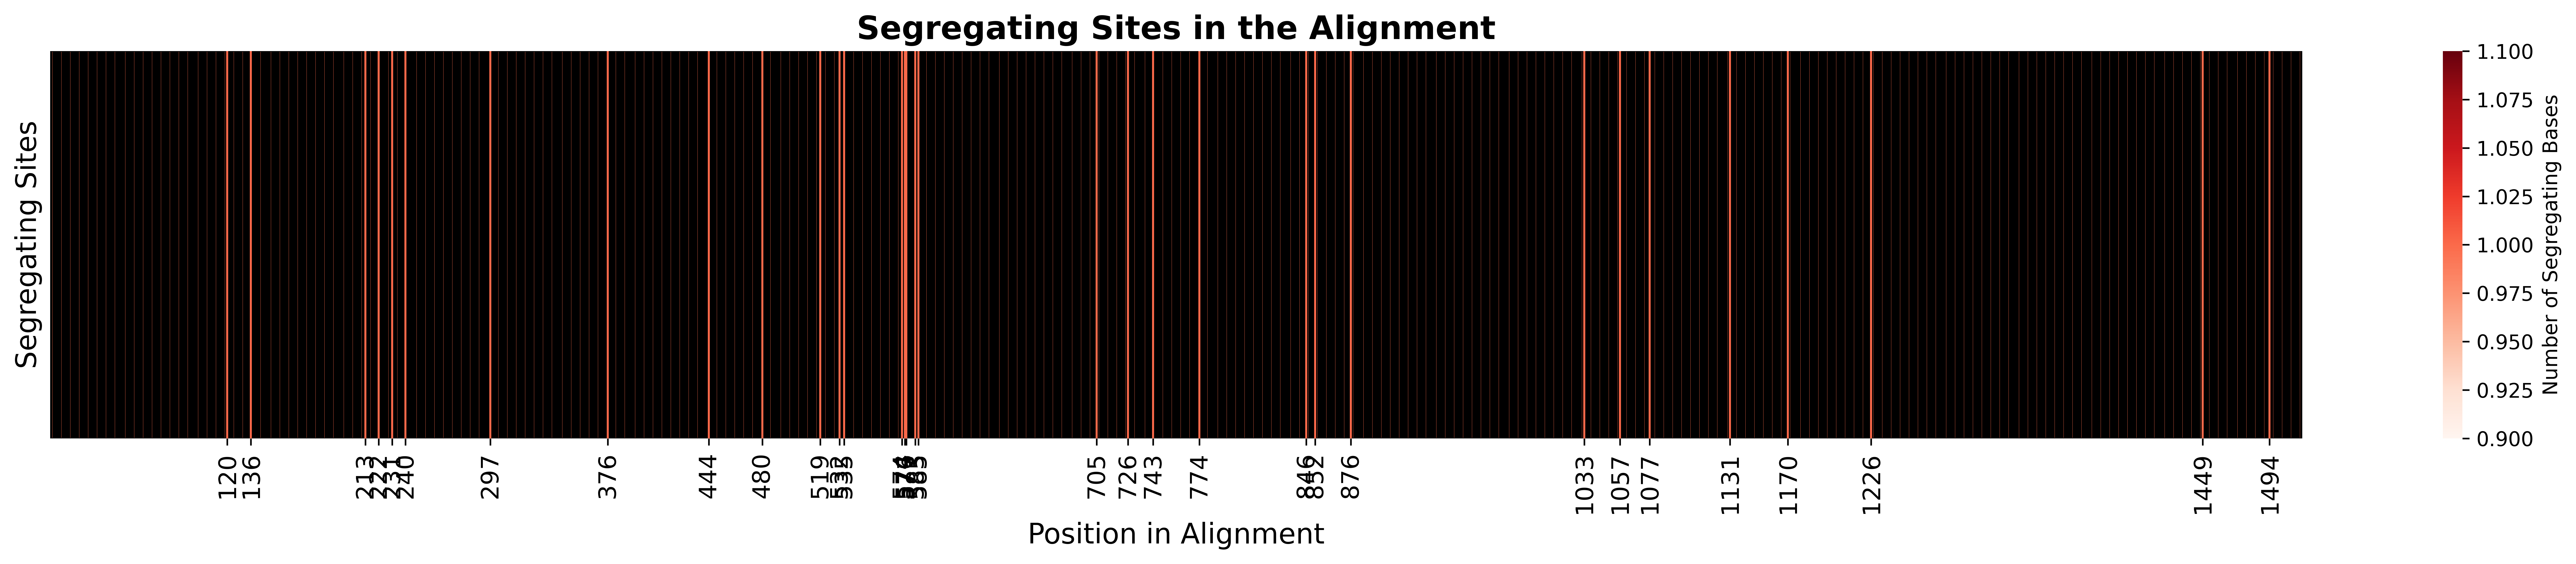

In [90]:
#@title Visualize Segregation sites
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def calculate_segregating_sites(alignment):
    num_sites = alignment.get_alignment_length()
    segregating_sites = []
    for i in range(num_sites):
        column = alignment[:, i]
        unique_bases = set(column)
        if len(unique_bases) > 1:
            segregating_sites.append(i)
    return segregating_sites

# Calculate segregating sites
segregating_sites = calculate_segregating_sites(alignment)
print(f"Segregating Sites: {len(segregating_sites)}")

# Create a matrix where the value indicates the number of segregating bases at each site
num_sites = alignment.get_alignment_length()
segregating_matrix = np.zeros((1, num_sites))
for i in range(num_sites):
    column = alignment[:, i]
    unique_bases = set(column)
    segregating_matrix[0, i] = len(unique_bases)

# Plot the segregating sites with position numbers
plt.figure(figsize=(20, 4), dpi=600)
cmap = plt.get_cmap('Reds')
ax = sns.heatmap(segregating_matrix, cmap=cmap, cbar=True, cbar_kws={'label': 'Number of Segregating Bases'}, xticklabels=False, yticklabels=False, linewidths=0.5, linecolor='black', annot=False, vmin=1, vmax=len(set(alignment[:, 0])))

# Set background color to light gray
ax.set_facecolor('lightgray')

# Set x-axis ticks only at the segregating site positions
ax.set_xticks(segregating_sites)
ax.set_xticklabels([str(site + 1) for site in segregating_sites], fontsize=12, rotation=90)

# Improve plot aesthetics
plt.title('Segregating Sites in the Alignment', fontsize=16, fontweight='bold')
plt.xlabel('Position in Alignment', fontsize=14)
plt.ylabel('Segregating Sites', fontsize=14)
plt.yticks(fontsize=12)

# Set grid color to match the legend
grid_color = cmap(0.5)  # Choose a middle value from the colormap
plt.grid(True, which='both', linestyle='-', linewidth=1.0, color=grid_color)

# Save the plot to a file
plt.tight_layout()
plt.savefig('segregating_sites_heatmap.png', dpi=600)
plt.show()

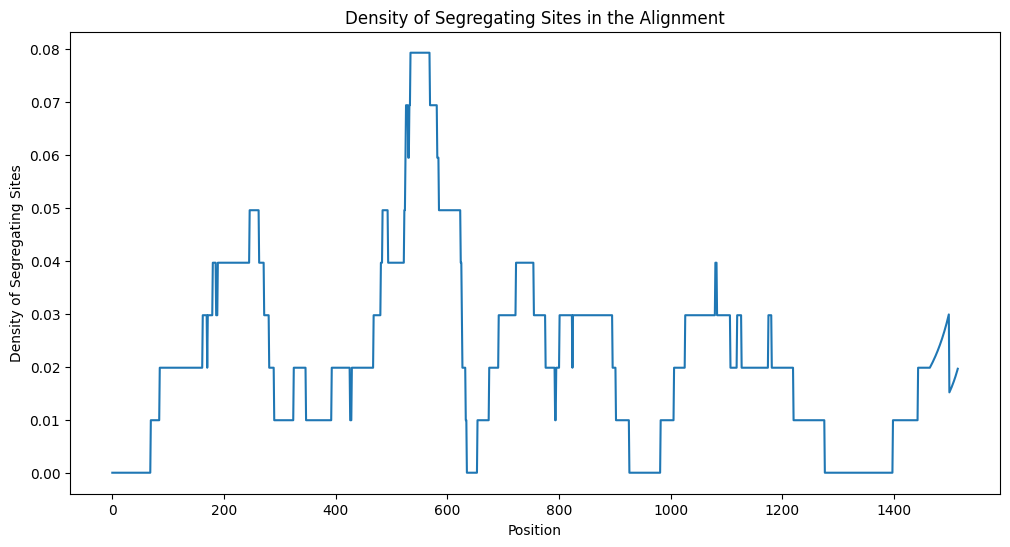

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO

# Load the alignment file
alignment = AlignIO.read("aligned_sequences.fas", "fasta")

# Calculate the density of segregating sites
segregating_sites = []
for i in range(alignment.get_alignment_length()):
    column = alignment[:, i]
    unique_bases = set(column)
    if len(unique_bases) > 1:
        segregating_sites.append(i)

# Calculate the density of segregating sites
density = np.zeros(alignment.get_alignment_length())
for site in segregating_sites:
    density[site] = 1

# Smooth the density using a sliding window
window_size = 100
smoothed_density = np.zeros(len(density))
for i in range(len(density)):
    start = max(0, i - window_size // 2)
    end = min(len(density), i + window_size // 2 + 1)
    smoothed_density[i] = np.mean(density[start:end])

# Plot the density
plt.figure(figsize=(12, 6))
plt.plot(smoothed_density)
plt.xlabel("Position")
plt.ylabel("Density of Segregating Sites")
plt.title("Density of Segregating Sites in the Alignment")

# Save the plot as a 600 dpi PNG
plt.savefig("segregating_sites_density.png", dpi=600, bbox_inches="tight")

plt.show()

In [2]:
#@title Calculate Haplotype Diversity
def calculate_haplotype_diversity(sequences):
    num_sequences = len(sequences)
    haplotypes = set(str(record.seq) for record in sequences)
    haplotype_counts = [sum(1 for record in sequences if str(record.seq) == haplotype) for haplotype in haplotypes]
    haplotype_freqs = [count / num_sequences for count in haplotype_counts]
    haplotype_diversity = 1 - sum(f ** 2 for f in haplotype_freqs)
    return haplotype_diversity

# Calculate haplotype diversity
haplotype_diversity = calculate_haplotype_diversity(sequences)
print(f"Haplotype Diversity: {haplotype_diversity}")

NameError: name 'sequences' is not defined

In [1]:
#@title Visualize Segregation sites
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def calculate_segregating_sites(alignment):
    num_sites = alignment.get_alignment_length()
    segregating_sites = []
    for i in range(num_sites):
        column = alignment[:, i]
        unique_bases = set(column)
        if len(unique_bases) > 1:
            segregating_sites.append(i)
    return segregating_sites

# Calculate segregating sites
segregating_sites = calculate_segregating_sites(alignment)
print(f"Segregating Sites: {len(segregating_sites)}")

# Create a matrix where the value indicates the number of segregating bases at each site
num_sites = alignment.get_alignment_length()
segregating_matrix = np.zeros((1, num_sites))
for i in range(num_sites):
    column = alignment[:, i]
    unique_bases = set(column)
    segregating_matrix[0, i] = len(unique_bases)

# Plot the segregating sites with position numbers
plt.figure(figsize=(40, 10), dpi=300)  # Increased figure size
cmap = plt.get_cmap('Reds')
ax = sns.heatmap(segregating_matrix, cmap=cmap, cbar=True, cbar_kws={'label': 'Number of Segregating Bases'}, xticklabels=False, yticklabels=False, linewidths=0.5, linecolor='black', annot=False, vmin=1, vmax=len(set(alignment[:, 0])))

# Set background color to light gray
ax.set_facecolor('lightgray')

# Set x-axis ticks only at the segregating site positions
ax.set_xticks(segregating_sites)
ax.set_xticklabels([str(site + 1) for site in segregating_sites], fontsize=18, rotation=90)  # Increased font size

# Improve plot aesthetics
plt.title('Segregating Sites in the Alignment', fontsize=24, fontweight='bold')  # Increased font size
plt.xlabel('Position in Alignment', fontsize=18)  # Increased font size
plt.ylabel('Segregating Sites', fontsize=18)  # Increased font size
plt.yticks(fontsize=18)  # Increased font size

# Set grid color to match the legend
grid_color = cmap(0.5)  # Choose a middle value from the colormap
plt.grid(True, which='both', linestyle='-', linewidth=2.0, color=grid_color)  # Increased line width

# Save the plot to a file
plt.tight_layout()
plt.savefig('segregating_sites_heatmap.png', dpi=300)
plt.show()

NameError: name 'alignment' is not defined

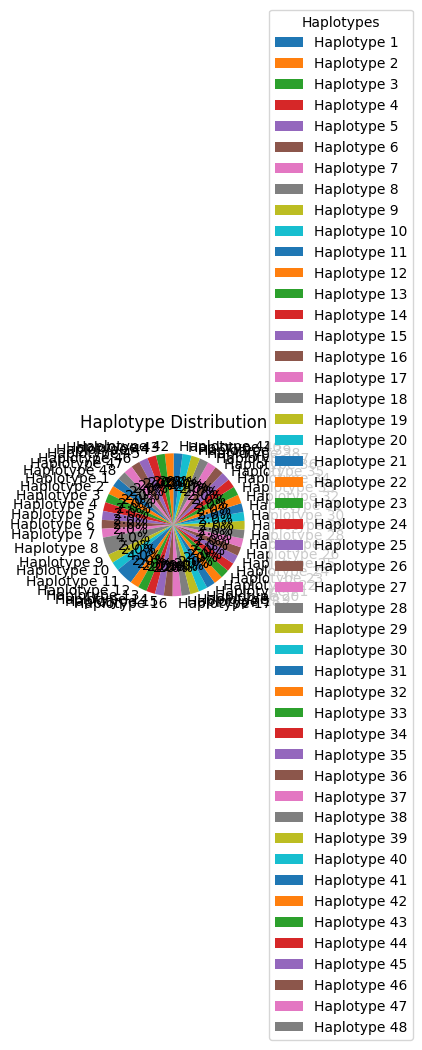

Haplotype 1:
  - gi|356692435|gb|HQ660398.1|
Haplotype 2:
  - gi|194473480|dbj|AB332245.1|
Haplotype 3:
  - gi|2668287555|dbj|LC791210.1|
Haplotype 4:
  - gi|2163734873|gb|OK847719.1|
Haplotype 5:
  - gi|2795781112|emb|OZ174032.1|
Haplotype 6:
  - gi|6230488|dbj|AB029383.1|
Haplotype 7:
  - gi|356692457|gb|HQ660409.1|
Haplotype 8:
  - gi|2475336194|dbj|LC744585.1|
  - gi|15383642|dbj|AB050991.1|
Haplotype 9:
  - gi|2843935922|dbj|LC814425.1|
Haplotype 10:
  - gi|9967376|dbj|AB039785.1|
Haplotype 11:
  - gi|2163734825|gb|OK847695.1|
  - gi|194473510|dbj|AB332260.1|
Haplotype 12:
  - gi|15383654|dbj|AB051218.1|
Haplotype 13:
  - gi|2163734845|gb|OK847705.1|
Haplotype 14:
  - gi|2163734847|gb|OK847706.1|
Haplotype 15:
  - gi|6249628|dbj|AB029386.1|
Haplotype 16:
  - gi|194473484|dbj|AB332247.1|
Haplotype 17:
  - gi|15383646|dbj|AB050993.1|
Haplotype 18:
  - gi|356692479|gb|HQ660420.1|
Haplotype 19:
  - gi|356692477|gb|HQ660419.1|
Haplotype 20:
  - gi|2217808833|dbj|LC702097.1|
Haplotype 2

In [54]:
#@title Create a mapping from haplotype label to members
haplotype_members = {f'Haplotype {i+1}': [] for i in range(len(unique_haplotypes))}
for record in sequences:
    haplotype_label = f'Haplotype {unique_haplotypes.index(str(record.seq))+1}'
    haplotype_members[haplotype_label].append(record.id)

# Pie chart for Haplotype Diversity
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(haplotype_counts, labels=[f'Haplotype {i+1}' for i in range(len(unique_haplotypes))],
                                   autopct='%1.1f%%', startangle=140)
plt.title('Haplotype Distribution')

# Add legend
plt.legend(wedges, [f'Haplotype {i+1}' for i in range(len(unique_haplotypes))],
           title="Haplotypes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Save the plot as a 600 DPI PNG image
plt.tight_layout()
plt.savefig("haplotype_frequency.png", dpi=600, format='png')  # High DPI save

plt.show()

# Print members of each haplotype
for haplotype, members in haplotype_members.items():
    print(f"{haplotype}:")
    for member in members:
        print(f"  - {member}")


Please enter the name of your sequence file (e.g., sequences.fas): aligned_sequences.fas
Haplotype Diversity: 0.9784


<ipython-input-57-d4389e4fb1aa>:53: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  haplotype_linkage = linkage(haplotype_distances, method='single')


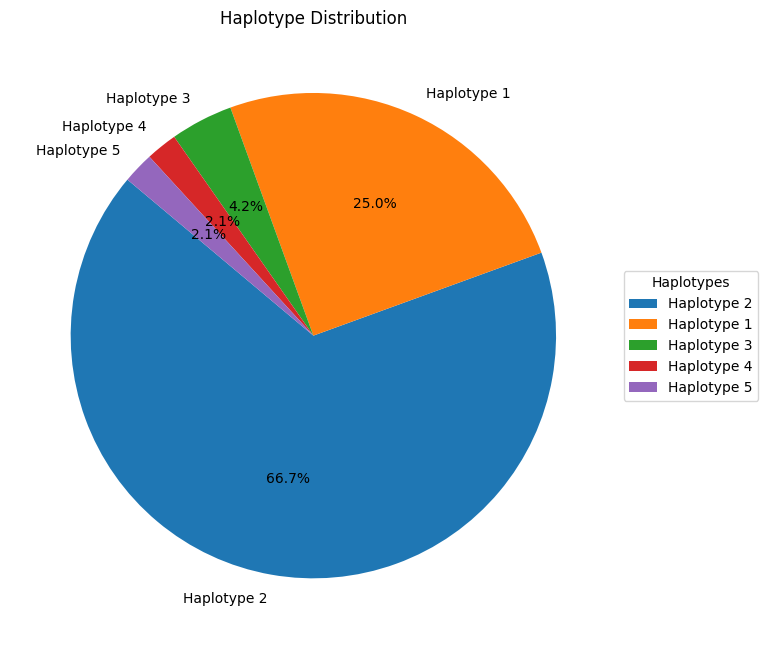

Haplotype 2:
 - gi|2668287555|dbj|LC791210.1|
 - gi|22852189|dbj|AB071411.1|
 - gi|763477707|gb|KP127074.1|
 - gi|763477705|gb|KP127073.1|
 - gi|15383662|dbj|AB051222.1|
 - gi|9967380|dbj|AB039787.1|
 - gi|2475336194|dbj|LC744585.1|
 - gi|1377593031|gb|KY782044.1|
 - gi|6230488|dbj|AB029383.1|
 - gi|15383656|dbj|AB051219.1|
 - gi|65736500|dbj|AB194961.1|
 - gi|6230590|dbj|AB029391.1|
 - gi|6230478|dbj|AB029167.1|
 - gi|9967376|dbj|AB039785.1|
 - gi|9967378|dbj|AB039786.1|
 - gi|35395976|gb|AY320255.1|
 - gi|9967384|dbj|AB039789.1|
 - gi|1313735012|dbj|LC215379.1|
 - gi|2843935922|dbj|LC814425.1|
 - gi|667665918|dbj|AB970711.1|
 - gi|356692479|gb|HQ660420.1|
 - gi|2217808865|dbj|LC702101.1|
 - gi|15383646|dbj|AB050993.1|
 - gi|2314712628|emb|OX344767.1|
 - gi|194473528|dbj|AB332269.1|
 - gi|2795781112|emb|OZ174032.1|
 - gi|194473484|dbj|AB332247.1|
 - gi|2163734829|gb|OK847697.1|
 - gi|6230425|dbj|AB024963.1|
 - gi|194473530|dbj|AB332270.1|
 - gi|2163734847|gb|OK847706.1|
 - gi|21637348

In [57]:
#@title Plot Haplotype Frequency through Matplot
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

def calculate_haplotype_diversity(sequences):
    """ Calculate haplotype diversity based on the sequence records.

    Parameters:
    - sequences: A list of sequence records from Biopython.

    Returns:
    - haplotype_diversity: Haplotype diversity index.
    """
    num_sequences = len(sequences)
    # Extract haplotypes and their counts
    haplotypes = [str(record.seq) for record in sequences]
    unique_haplotypes = list(set(haplotypes))
    haplotype_counts = [haplotypes.count(haplotype) for haplotype in unique_haplotypes]
    # Calculate frequencies
    haplotype_freqs = [count / num_sequences for count in haplotype_counts]
    # Calculate haplotype diversity using Simpson's index
    haplotype_diversity = 1 - sum(f ** 2 for f in haplotype_freqs)
    return unique_haplotypes, haplotype_counts, haplotype_diversity

def hamming_distance(haplotype1, haplotype2):
    return sum(el1 != el2 for el1, el2 in zip(haplotype1, haplotype2))

# Get file name from user
file_name = input("Please enter the name of your sequence file (e.g., sequences.fas): ")

# Load sequences from file
try:
    sequences = list(SeqIO.parse(file_name, "fasta"))
except FileNotFoundError:
    print(f"Sorry, the file {file_name} does not exist.")
    exit()

# Calculate haplotype diversity and get haplotype data
unique_haplotypes, haplotype_counts, haplotype_diversity = calculate_haplotype_diversity(sequences)
print(f"Haplotype Diversity: {haplotype_diversity}")

# Calculate distances between haplotypes using Hamming distance
haplotype_distances = np.zeros((len(unique_haplotypes), len(unique_haplotypes)))
for i in range(len(unique_haplotypes)):
    for j in range(i+1, len(unique_haplotypes)):
        haplotype_distances[i, j] = hamming_distance(unique_haplotypes[i], unique_haplotypes[j])
        haplotype_distances[j, i] = haplotype_distances[i, j]

# Perform hierarchical clustering on the haplotypes
haplotype_linkage = linkage(haplotype_distances, method='single')
haplotype_clusters = fcluster(haplotype_linkage, 5, criterion='maxclust')  # Adjust the number of clusters as needed

# Create a mapping from haplotype label to members
haplotype_members = {}
for i, cluster in enumerate(haplotype_clusters):
    haplotype_label = f'Haplotype {cluster}'
    if haplotype_label not in haplotype_members:
        haplotype_members[haplotype_label] = []
    # Get the sequence name (id) instead of the sequence itself
    sequence_name = sequences[i].id
    haplotype_members[haplotype_label].append(sequence_name)

# Plot the haplotype distribution
haplotype_counts = [len(members) for members in haplotype_members.values()]
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(haplotype_counts, labels=list(haplotype_members.keys()), autopct='%1.1f%%', startangle=140)
plt.title('Haplotype Distribution')

# Add legend
plt.legend(wedges, list(haplotype_members.keys()), title="Haplotypes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Save the plot as a 600 DPI PNG image
plt.tight_layout()
plt.savefig("haplotype_frequency.png", dpi=600, format='png')

# Show the plot
plt.show()

# Print members of each haplotype
for haplotype, members in haplotype_members.items():
    print(f"{haplotype}:")
    for member in members:
        print(f" - {member}")

In [59]:
#@title Haplotype Networking
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

def hamming_distance(seq1, seq2):
    """Calculate the Hamming distance between two sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def create_haplotype_network(haplotypes):
    """Create a haplotype network based on Hamming distances."""
    G = nx.Graph()

    # Add nodes (haplotypes)
    for haplotype in haplotypes:
        G.add_node(haplotype)

    # Calculate pairwise distances and add edges
    for hap1, hap2 in combinations(haplotypes, 2):
        distance = hamming_distance(hap1, hap2)
        G.add_edge(hap1, hap2, weight=distance)

    return G

# Example sequences (replace with your actual data)
haplotypes = [str(record.seq) for record in sequences]  # Convert sequences to haplotypes

# Create the haplotype network
G = create_haplotype_network(haplotypes)

<ipython-input-60-4ba48668d7d3>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(set(haplotypes)))


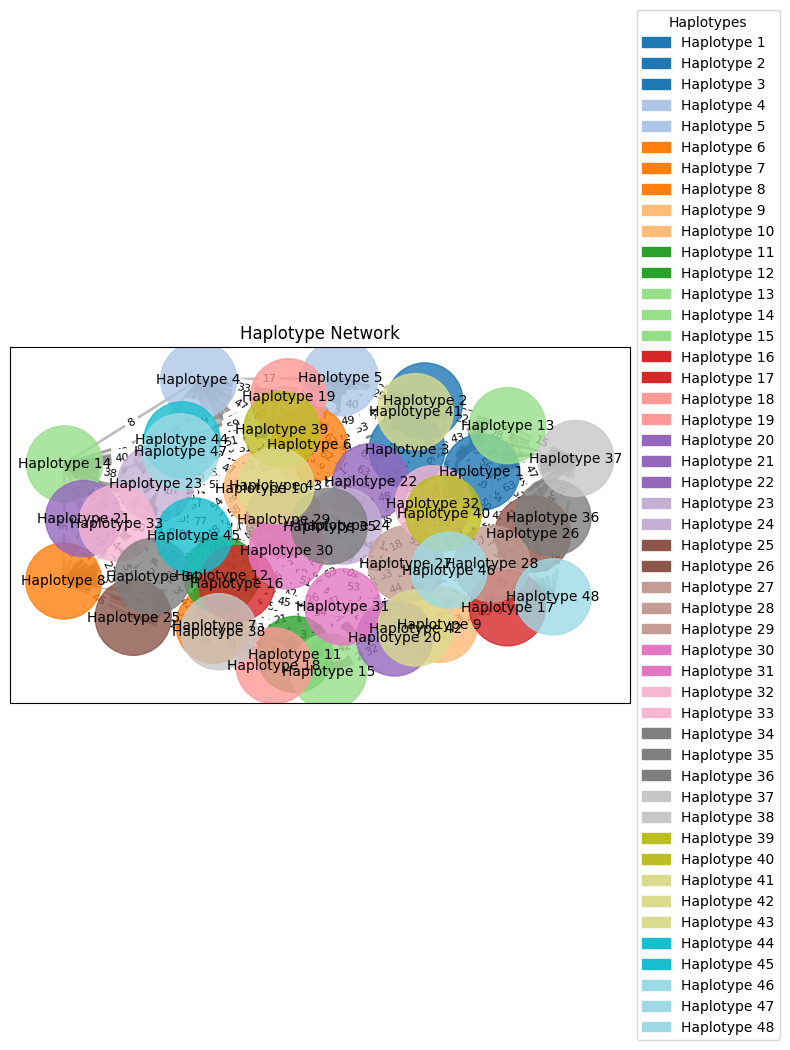

In [60]:
#@title Run it
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.patches as mpatches
import numpy as np

def hamming_distance(seq1, seq2):
    """Calculate the Hamming distance between two sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def create_haplotype_network(haplotypes):
    """Create a haplotype network based on Hamming distances."""
    unique_haplotypes = list(set(haplotypes))  # Extract unique haplotypes
    haplotype_to_label = {hap: f'Haplotype {i+1}' for i, hap in enumerate(unique_haplotypes)}

    G = nx.Graph()

    # Add nodes with haplotype labels
    for hap in unique_haplotypes:
        G.add_node(hap, label=haplotype_to_label[hap])

    # Calculate pairwise distances and add edges
    for hap1, hap2 in combinations(unique_haplotypes, 2):
        distance = hamming_distance(hap1, hap2)
        G.add_edge(hap1, hap2, weight=distance)

    return G, haplotype_to_label

# Example sequences (replace with your actual data)
# Extract haplotypes
haplotypes = [str(record.seq) for record in sequences]

# Create the haplotype network
G, haplotype_to_label = create_haplotype_network(haplotypes)

# Generate a color map for haplotypes
colors = plt.cm.get_cmap('tab20', len(set(haplotypes)))

# Assign a color to each haplotype
haplotype_colors = {hap: colors(i) for i, hap in enumerate(set(haplotypes))}

# Draw the network
plt.figure(figsize=(8, 8))

# Compute positions using a layout algorithm
pos = nx.spring_layout(G, seed=42)  # Use seed for reproducibility

# Draw nodes with specific colors
node_colors = [haplotype_colors[hap] for hap in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')

# Draw node labels
nx.draw_networkx_labels(G, pos, labels={node: haplotype_to_label[node] for node in G.nodes()}, font_size=10, font_family='sans-serif')

# Draw edge labels (distances)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Prepare legend with haplotype labels and colors
handles = [mpatches.Patch(color=haplotype_colors[hap], label=label) for hap, label in haplotype_to_label.items()]
plt.legend(handles=handles, title="Haplotypes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Haplotype Network')
plt.tight_layout()
# Save the plot as a 600 DPI PNG image
plt.savefig("haplotype_network.png", dpi=600, format='png')  # High DPI save

# Show the plot
plt.show()

<ipython-input-61-e5cdbcb87638>:24: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  haplotype_linkage = linkage(haplotype_distances, method='single')
<ipython-input-61-e5cdbcb87638>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(haplotype_members))


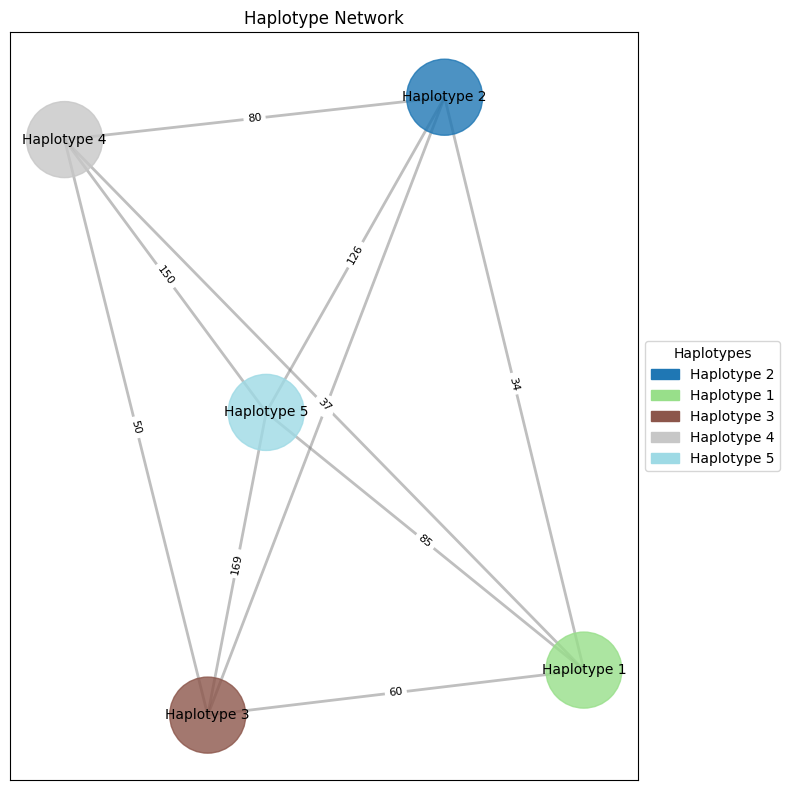

In [61]:
#@title Run it
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.patches as mpatches
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

def hamming_distance(seq1, seq2):
    """Calculate the Hamming distance between two sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def create_haplotype_network(haplotypes):
    """Create a haplotype network based on Hamming distances."""
    unique_haplotypes = list(set(haplotypes))

    # Perform hierarchical clustering on the haplotypes
    haplotype_distances = np.zeros((len(unique_haplotypes), len(unique_haplotypes)))
    for i in range(len(unique_haplotypes)):
        for j in range(i+1, len(unique_haplotypes)):
            haplotype_distances[i, j] = hamming_distance(unique_haplotypes[i], unique_haplotypes[j])
            haplotype_distances[j, i] = haplotype_distances[i, j]
    haplotype_linkage = linkage(haplotype_distances, method='single')
    haplotype_clusters = fcluster(haplotype_linkage, 5, criterion='maxclust')

    # Create a mapping from haplotype label to members
    haplotype_members = {}
    for i, cluster in enumerate(haplotype_clusters):
        haplotype_label = f'Haplotype {cluster}'
        if haplotype_label not in haplotype_members:
            haplotype_members[haplotype_label] = []
        haplotype_members[haplotype_label].append(unique_haplotypes[i])

    # Create the haplotype network
    G = nx.Graph()
    for haplotype, members in haplotype_members.items():
        G.add_node(haplotype, label=haplotype)
    for hap1, members1 in haplotype_members.items():
        for hap2, members2 in haplotype_members.items():
            if hap1 != hap2:
                distance = min(hamming_distance(hap1, hap2) for hap1 in members1 for hap2 in members2)
                G.add_edge(hap1, hap2, weight=distance)

    return G, haplotype_members

# Example sequences (replace with your actual data)
haplotypes = [str(record.seq) for record in sequences]

# Create the haplotype network
G, haplotype_members = create_haplotype_network(haplotypes)

# Generate a color map for haplotypes
colors = plt.cm.get_cmap('tab20', len(haplotype_members))

# Assign a color to each haplotype
haplotype_colors = {hap: colors(i) for i, hap in enumerate(haplotype_members)}

# Draw the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)
node_colors = [haplotype_colors[hap] for hap in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10, font_family='sans-serif')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Prepare legend with haplotype labels and colors
handles = [mpatches.Patch(color=haplotype_colors[hap], label=hap) for hap in haplotype_members]
plt.legend(handles=handles, title="Haplotypes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Haplotype Network')
plt.tight_layout()
plt.savefig("haplotype_network.png", dpi=600, format='png')
plt.show()